In [1]:
!pip install "deeplake<4"
!pip install --upgrade transformers
!pip install nltk
!pip install torchvision

In [2]:
import torch
import torch.nn as nn

import deeplake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms
from transformers import BertTokenizer, BertModel
import nltk
import random

from torch.utils.data import Dataset
from PIL import Image

/usr/local/lib/python3.10/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## Preprocess Data

In [3]:
ds = deeplake.load('hub://activeloop/flickr30k')

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k



|

hub://activeloop/flickr30k loaded successfully.



In [4]:
images = ds.image
captions = ds.caption_0 ## NextSteps: currently only training on caption0, could include other set of captions

### Tokenizing

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
## ALL Hyperparameters
caption_max_length = 20
vocab_size = len(tokenizer)

In [7]:
def process_image(image):
  """
  Image transformation functions
  Resizes images to 224x224, converts to tensor, and normalizes
  The normalization parameters are mean, SD of of r, g, b pixel values
  """
  image_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  image = image.numpy()
  image = Image.fromarray(image)
  image = image_transform(image)
  return image


def process_caption(caption_text):
  """
  Tokenizes captions
  Returns tensor of tokenized captions, with a max length of 20,
  padding until this length, and truncating if the caption is longer
  The individual entries in the tensor are integers
  """

  tokenized = tokenizer(caption_text,
                        max_length=caption_max_length,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt')

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']
  return input_ids

def untokenize(tokenized_text):
    """
    Untokenizes a tensor
    Takes a tensor of integers, and according to tokenizer, returns
    original words
    """
    return tokenizer.decode(tokenized_text, skip_special_tokens=True)


#### Tests

tests for tokenizer

In [8]:
strings = ["hello world", "my dog went to the store", "the earth revolves around the sun",
           "I travelled to new york city and ate mexican and japanese food"]

def test_tokenizer(strings):
    """
    Function to test tokenizer, by tokenizing and untokenizing a string
    """
    for string in strings:
        # print ("input string: " + string)
        check = untokenize(process_caption(string)[0])
        # print ("output string: " + check)
        assert check.lower() == string.lower()
    print("All tests passed!")
test_tokenizer(strings)

All tests passed!


In [9]:
tokenizer.tokenize("Hello I am Wendy")
tokenizer.encode("Hello I am Wendy", add_special_tokens = True)

[101, 7592, 1045, 2572, 12815, 102]

### tests for data processing

In [10]:
def test_process_image():
  test_img = ds.image[0]
  transformed_img = process_image(test_img)
  assert transformed_img.size(1) == 224 and transformed_img.size(2) == 224, "Image resizing failed."
  assert transformed_img.size(0) == 3, "Image channel mismatch."
  print("All tests passed!")

test_process_image()


All tests passed!


In [11]:
def test_process_caption():
  caption = "A dog playing in the park."
  input_ids = process_caption(caption)
  assert input_ids.size(1) == 20, "Tokenized length incorrect."

  decoded_caption = untokenize(input_ids[0])
  assert decoded_caption.lower() == caption.lower(), "Caption untokenization incorrect."
  print("All tests passed!")
test_process_caption()

All tests passed!


### Dataset/Dataloader Creation

In [12]:
class Flickr30kDataset(Dataset):
    def __init__(self, images, captions, image_transform=None, caption_transform = None):
      """
      Initializes dataset
      """
      self.images = images
      self.captions = captions
      self.image_transform = image_transform
      self.caption_transform = caption_transform

    def __len__(self):
      """
      Returns length of the dataset
      """
      return len(self.captions)

    def __getitem__(self, idx):
      """
      Returns a single item (image, and caption processed according to
      caption_transform) from the dataset
      """
      image = self.images[idx]
      image = self.image_transform(image)

      caption = self.captions[idx].numpy()[0]
      caption_embedding = self.caption_transform(caption)
      return image, caption_embedding


In [13]:
from torch.utils.data import DataLoader, random_split

flickr_dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)

# 80% train, 10% val, 10% Test
train_size = int(0.8 * len(flickr_dataset))
val_size = int(0.1 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_dataset, eval_dataset, test_dataset = random_split(flickr_dataset, [train_size, val_size, test_size])

batch_size = 32 # TODO
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
## SMALLER DATASET FOR SAMPLE
from torch.utils.data import Subset
import random

# TODO:
train_n = 10
eval_n = 2
batch = 1

train_indices = random.sample(range(len(flickr_dataset)), train_n)
train_subset = Subset(flickr_dataset, train_indices)
mini_train_dataloader = DataLoader(train_subset, batch_size=batch, shuffle=False)

eval_indices = random.sample(range(len(flickr_dataset)), eval_n)
eval_subset = Subset(flickr_dataset, eval_indices)
mini_eval_dataloader = DataLoader(eval_subset, batch_size=batch, shuffle=False)

#### Tests

tests for dataset

In [15]:
def test_flickr30k_dataset():
    dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)
    assert len(dataset) == len(captions), "Dataset length mismatch."

    image, caption_embedding = dataset[0]
    assert image.size(0) == 3 and image.size(1) == 224 and image.size(2) == 224, "Image shape incorrect."
    assert caption_embedding.size(1) == 20, "Caption max length incorrect."
    print("All tests passed!")

test_flickr30k_dataset()

All tests passed!


## CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    """
    Initializes convolutional neural network
    """
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)

    self.relu = nn.ReLU()
    self.fc = nn.Linear(in_features=288, out_features=1024)
    self.fc2 = nn.Linear(1024, 256)
    self.flatten = nn.Flatten()

    self.maxPool = nn.MaxPool2d((2, 2), stride=2)

    self.batchNorm1 = nn.BatchNorm2d(4)
    self.batchNorm2 = nn.BatchNorm2d(16)
    self.batchNorm3 = nn.BatchNorm2d(32)

  def forward(self, x):
    """
    Forward pass of convolutional neural network
    """
    # for each layer, run convolutional layer, batch normalization layer,
    # then maxPool layer
    layer1 = self.maxPool(self.relu(self.batchNorm1(self.conv1(x))))
    layer2 = self.maxPool(self.relu(self.batchNorm2(self.conv2(layer1))))
    layer3 = self.maxPool(self.relu(self.batchNorm3(self.conv3(layer2))))
    x1 = self.flatten(layer3)
    # print(x1.shape) # 1, 288
    hidden = self.relu(self.fc(x1)) #1, 1024
    x = self.fc2(hidden) # 1, 4
    # print(x.shape )
    return x


#### Tests

Tests for CNN

In [ ]:
def test_cnn_forward_pass():
    cnn_model = CNN().to("cpu")
    test_img = torch.randn(1, 3, 224, 224).to("cpu")
    features = cnn_model(test_img)
    assert features.size(1) == 256, "CNN dimension incorrect."

test_cnn_forward_pass()

## RNN

In [ ]:
print("vocab size", tokenizer.vocab_size)
print("embed dim", bert_model.config.hidden_size)


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size = 30522, embed_dim = 768, feature_dim = 256, hidden_dim= 512, max_length= 20):
      """
      Initializes RNN
      vocab_size = vocab size of bert tokenizer
      embed_dim = bert_model config hidden size
      feature_dim = from CNN output
      hidden_dim = hidden dimension of RNN
      """

      super(DecoderRNN, self).__init__()
      # embedding layer
      self.embedding = nn.Embedding(vocab_size, embed_dim)
      # long-short term memory nodes
      self.lstm = nn.LSTM(embed_dim + feature_dim, hidden_dim, batch_first=True)
      self.fc = nn.Linear(hidden_dim, vocab_size)
      self.max_length = max_length
      self.hidden_dim = hidden_dim

    def init_hidden(self, batch_size):
      """
      initialize hidden layer of model
      """
      return (torch.zeros(1, batch_size, self.hidden_dim).to(device), # h
              torch.zeros(1, batch_size, self.hidden_dim).to(device)) # c

    def forward(self, features, captions, hidden = None):
      """
      Runs one step of RNN
      """
      # Note: Initial caption is the <START> token
      embeddings = self.embedding(captions)  # (batch_size, max_length, embed_dim)
      features = torch.unsqueeze(features, 1) # (batch, 1, feature )
      inputs = torch.cat((features, embeddings), dim=2)  # (batch_size, max_length, embed_dim + feature_dim)

      lstm_out, hidden = self.lstm(inputs, hidden)  # (batch_size, max_length, hidden_dim)
      outputs = self.fc(lstm_out)  # (batch_size, max_length, vocab_size)
      return outputs, hidden


## TRAIN




In [ ]:
def train_model(cnn, rnn, data_loader, ratio = 0.5, device="cpu"):
  cnn.train()
  rnn.train()
  for epoch in range(num_epochs):
    total_loss = 0.0
    for images, captions in data_loader:
      images = images.to(device)
      captions = captions.to(device).long()

      batch_size = len(images) # for each item images set how many are there
      hidden = rnn.init_hidden(batch_size)

      optimizer_cnn.zero_grad()
      optimizer_rnn.zero_grad()

      features = cnn(images)
      captions = captions.squeeze(1)

      # Get the <Start> token
      decoder_input = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

      outputs = []

      # Teacher-forcing alg
      if random.random() < ratio:
        use_force = True
      else:
        use_force = True

      # Note RNN predicts one step ahead - cuz of the <start> token
      seq_length = captions.size(1)
      for t in range(1, seq_length):

          output, hidden = rnn(features, decoder_input, hidden)
          outputs.append(output)

          if use_force:
              decoder_input = captions[:, t].unsqueeze(1) # use true caption
          else:
              decoder_input = output.argmax(dim=2)

      outputs = torch.cat(outputs, dim=1)  # (batch , seq length - 1, vocab_size) 2, 19, vocabsize
      outputs = outputs.reshape(-1, outputs.size(2))  # batch * (seqlength - 1), vocab_size

      caption_original = captions[:, 1:]  #( batch , (seqlength - 1) )
      caption_original = caption_original.contiguous().view(-1) #batch * (seqlength - 1)

      print (outputs.shape)
      print (caption_original.shape)

      loss = criterion(outputs, caption_original)

      loss.backward()
      optimizer_cnn.step()
      optimizer_rnn.step()
      total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save model after each epoch
    # cnn_save_path = f'{home}cnn_epoch_{epoch + 1}.pth'
    # rnn_save_path = f'{home}rnn_epoch_{epoch + 1}.pth'
    # optimizer_cnn_save_path = f'{home}optimizer_cnn_epoch_{epoch + 1}.pth'
    # optimizer_rnn_save_path = f'{home}optimizer_rnn_epoch_{epoch + 1}.pth'

    # torch.save(cnn.state_dict(), cnn_save_path)
    # torch.save(rnn.state_dict(), rnn_save_path)
    # torch.save(optimizer_cnn.state_dict(), optimizer_cnn_save_path)
    # torch.save(optimizer_rnn.state_dict(), optimizer_rnn_save_path)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model = CNN().to(device)
rnn_model = DecoderRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

num_epochs = 10


In [ ]:
train_model(cnn_model, rnn_model, mini_train_dataloader, device=device)

## Eval

In [ ]:
def eval_model(cnn, rnn, data_loader, device):
  cnn.eval()
  rnn.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, captions in data_loader:
      images = images.to(device)
      captions = captions.to(device).long()
      captions = captions.squeeze(1)

      # set batch and hidden
      batch_size = len(images)
      hidden = rnn.init_hidden(batch_size)

      features = cnn(images)
      decoder_input = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device) # start
      seq_length = captions.size(1)

      outputs = []

      for t in range(1, seq_length):
          output, hidden = rnn(features, decoder_input, hidden)

          decoder_input = output.argmax(dim=2)
          outputs.append(output)

      outputs = torch.cat(outputs, dim=1) #stack
      outputs = outputs.reshape(-1, outputs.size(2))

      caption_original = captions[:, 1:]
      caption_original = caption_original.contiguous().view(-1) #batch * (seqlength - 1)

      loss = criterion(outputs, caption_original)
      total_loss += loss.item()

  avg_loss = total_loss / len(data_loader)

  print(f"Validation Loss: {avg_loss:.4f}")
  return avg_loss


In [ ]:
eval_model(cnn_model, rnn_model, mini_eval_dataloader, device=device)

## Predict

In [ ]:
def predict(cnn, rnn, image, device='cpu'):
  cnn.eval()
  rnn.eval()
  image = image.to(device)

  with torch.no_grad():
      features = cnn(image)


  batch_size = 1
  max_length = 20

  start_token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

  hidden = rnn.init_hidden(batch_size)
  predictions = []
  input = start_token

  for _ in range(max_length):
      with torch.no_grad():
          output, hidden = rnn(features, input, hidden)
          # print(output[0])
          predicted_token = output.argmax(dim=2)
          # print(predicted_token)
          predictions.append(predicted_token.item())

          input = predicted_token

          # if predict a </e> end token, Exit
          if predicted_token.item() == tokenizer.sep_token_id:
              break

  predictions = untokenize(predictions)
  return predictions

Sample run

In [ ]:
## SAMPLE RUN
index = 9
test_image = ds.image[index]
plt.imshow(test_image.numpy())
print("caption:" , ds.caption_0[index].numpy())

## Process this test_image
processed_test_image = process_image(test_image).unsqueeze(0)
predicted_caption = predict(cnn_model, rnn_model, processed_test_image, device=device)
print("Predicted Caption:", predicted_caption)

# Trying out Transformers
Idea from : https://www.tensorflow.org/text/tutorials/image_captioning

Steps :  

1. Feature Extraction of Image (CNN)

2. Word Embedding : word + positional embedding

3. Decode Layer : Self attention, Cross Attention, Feed Forward Neural Network

4. Output : Post Processing of probability vector

## Feature Extraction

In [16]:
class CNN_feature_extraction(nn.Module):
  def __init__(self):
    """
    Initializes convolutional neural network
    """
    super(CNN_feature_extraction, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) # (224,224,64)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)# (224,224,128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)# (224,224,256)

    self.relu = nn.ReLU()
    self.fc = nn.Linear(256 * 28 * 28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.flatten = nn.Flatten()

    self.maxPool = nn.MaxPool2d(2, 2)

    self.batchNorm1 = nn.BatchNorm2d(64)
    self.batchNorm2 = nn.BatchNorm2d(128)
    self.batchNorm3 = nn.BatchNorm2d(256)

  def forward(self, x):
    """
    Forward pass of convolutional neural network
    Note: Output is already flattened
    """
    # for each layer, run convolutional layer, batch normalization layer,
    # then maxPool layer
    layer1 = self.maxPool(self.relu(self.batchNorm1(self.conv1(x)))) # batch_size, 64, 112, 112 (b, c , h, w )
    layer2 = self.maxPool(self.relu(self.batchNorm2(self.conv2(layer1)))) # batch_size, 128, 56, 56
    layer3 = self.maxPool(self.relu(self.batchNorm3(self.conv3(layer2)))) # batch_size, 256, 28, 28
    x1 = self.flatten(layer3)  # 1, 200704 = 256*28*28
    hidden = self.relu(self.fc(x1))
    x = self.fc2(hidden) # 1, 256
    return x

#### Tests for feature extractions

In [17]:
def test_feature_extraction():
    data_iter = iter(mini_eval_dataloader)
    batch = next(data_iter)
    images, labels = batch

    image = images[0]
    label = labels[0]  # Corresponding label (if available)

    feature_extractor = CNN_feature_extraction()
    features = feature_extractor(image.unsqueeze(0))
    assert features.size(0) == 1, "CNN dimension batch size incorrect."
    assert features.size(1) == 256, "CNN dimension incorrect."
    print("Test Passed!")

test_feature_extraction()

Test Passed!


## Embedding Layer
Embedding = Word + Positional Embedding.

In [18]:
## Hyperparameter
embed_dim = 256

In [19]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_length, dim):
        """
        Combines token and positional embeddings to produce sequence embeddings for Transformers.
        Input:
          vocab_size: size of vocab. Used for token embedding
          max_length: max length of caption. Used for positional embedding
          dim: Dimension of embedding vectors. Dimension of both token and positional Embedding
        """

        super().__init__()
        self.pos_embedding = nn.Embedding(num_embeddings=max_length, embedding_dim=dim)
        self.token_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim, padding_idx=0) # ie padding_idx that = 0 will not be trained

    def forward(self, caption):
        """
          Input: Caption (batch, max_length = 20)
          Output: Embedding (batch, max_length, dim)
        """
        _, max_length = caption.shape

        token_embed = self.token_embedding(caption)

        # Create a positional array with length = caption length (20)
        positional_indices = torch.arange(max_length, device=caption.device).unsqueeze(0) # 1, 20
        position_embed = self.pos_embedding(positional_indices)

        return token_embed + position_embed

#### Test for embedding layer

In [20]:
def test_embedding_layer():
    data_iter = iter(mini_eval_dataloader)
    batch = next(data_iter)
    images, labels = batch

    image = images[0]
    label = labels[0]  # Corresponding label (if available)

    embedding = Embedding(vocab_size,caption_max_length,embed_dim)
    seq_embed = embedding(label)
    assert seq_embed.shape == (1,caption_max_length,embed_dim), "CNN dimension incorrect."
    print("Test Passed!")

test_embedding_layer()

Test Passed!


## Decoder
Contains self attention, cross attention, feed forward neural network

In [21]:
## Hyperparameter
num_heads = 1
dropout =  0.1

### Self Attention Layer

In [22]:
class SelfAttention(nn.Module):
    """
    Self-Attention mechanism for token embeddings. Capture dependencies between words.

    Inputs:
        embed_dim: Embedding dimension = embed_dim
        num_heads: The number of attention heads. Each head learns different aspects of the relationships between tokens.
        dropout: Dropout rate used to prevent overfitting
    """
    def __init__(self,  num_heads = 1, embed_dim = embed_dim, dropout=0.1):
        super(SelfAttention, self).__init__()

        print ("embed dim is ", embed_dim)

        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x_token):
        """
        input shape : (batch, max_length, dim)
        output shape : (batch, max_length, dim)
        """
        attn_output, attn_output_weights = self.attention(query=x_token, key=x_token, value=x_token)
        x = x_token + attn_output  #Residual connection prevent vanishing grad
        return self.layernorm(x)

### Cross Attention Layer

In [23]:
class CrossAttention(nn.Module):
    """
    Cross Attention between caption and image.

    Input:
        Caption Embedding : (batch, seq_length, embed_dim)
        Image Feature Extraction : (batch, 256)
    """

    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super(CrossAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, caption, image):
        batch_size_c, seq_length, embed_dim = caption.shape
        batch_size_i, image_embed = image.shape
        assert batch_size_c == batch_size_i, "Batch Dimension of image and caption does not match"
        assert image_embed == 256, "Image Shape Incorrect"
        assert image_embed == embed_dim , "Image dimension does not match Token dimension"

        # create the same image for seq_length
        image_broadcasted = image.unsqueeze(1).repeat(1, seq_length, 1) # batch, seq_length, image_dim
        attn_output, attention_scores = self.mha(query=caption, key=image_broadcasted, value=image_broadcasted)
        caption = caption + attn_output  # Residual connection
        self.last_attention_scores = attention_scores
        return self.layernorm(caption)  #(batch, max_length, image_dim)

#### Tests for Cross Attention

### Feed Forward Neural Network

In [24]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(embed_dim, 2 * embed_dim),
            nn.ReLU(),
            nn.Linear(2 * embed_dim, embed_dim),
            nn.Dropout(dropout_rate)
        )
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.layer(x)
        return self.layernorm(x)


### Decoder Layer

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention = SelfAttention(num_heads, embed_dim, dropout)
        self.cross_attention = CrossAttention(embed_dim, num_heads, dropout)
        self.ffnn = FeedForward(embed_dim, dropout)

    def forward(self, inputs):
        image, caption = inputs
        caption_1 = self.self_attention(caption)
        output_seq = self.cross_attention(caption_1, image)
        out_seq = self.ffnn(output_seq)

        self.last_attention_scores = self.cross_attention.last_attention_scores

        return out_seq # batch, seq_length, embed_dim

## Combine + Data PostProcessing

1. Problem: Some tokens occur much more frequently than others in the dataset.
Without adjustment, the model may develop a bias toward predicting these frequent tokens, regardless of context.
Incorporate token frequency information in the logits using the bias term.
For instance, less frequent tokens are given a higher weight, encouraging the model to predict them when appropriate.

2. Problem: Some tokens, like [UNK] or [START], are placeholders or special tokens not intended for prediction.
Solution:
Add a large negative bias (-1e9) to these tokens' logits to make their probabilities effectively zero after softmax.
This guarantees they are not predicted during decoding.

In [26]:
import collections
from tqdm import tqdm

In [33]:
class PostProcessing(nn.Module):
    def __init__(self, embed_dim, tokenizer, banned_tokens=('[UNK]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a')):

        super(PostProcessing, self).__init__()
        self.vocab_size = tokenizer.vocab_size
        self.tokenizer = tokenizer
        self.fc = nn.Linear(embed_dim, out_features=tokenizer.vocab_size) ## Goal is to map to vocab size # batch, seq_length, vocab_size
        self.banned_tokens = banned_tokens

        self.bias = None

    def adapt(self, dataset):
        """
            vocab_dict: a dictionary to map vocab word to assigned index (from 0 to vocab_size)
            counts : a dictionary holding frequency of each word(token), key: id value :freq
        """
        counts = collections.Counter()
        vocab_dict = {name: id for id, name in enumerate(self.tokenizer.vocab)} # map name to id


        for tokens in tqdm(dataset):
            counts.update(tokens.numpy().flatten())  # Update freq for token in the sentence

        # Turn Frequency into an array of all vocabulary
        # fill vocab array with freq
        # array indices = token_id
        counts_arr = np.zeros(shape=(self.vocab_size,))
        indices = np.array(list(counts.keys()), dtype=np.int32)
        counts_arr[indices] = list(counts.values())


        for token in self.banned_tokens:
            id = vocab_dict[token]
            counts_arr[id] = 0

        total = counts_arr.sum()
        p = counts_arr / total
        p[counts_arr == 0] = 1.0  # Prevent log(0)
        log_p = np.log(p)  # log(1) == 0

        entropy = -(log_p * p).sum()

        # print(f"\nUniform entropy: {np.log(self.tokenizer.vocab_size):0.2f}")
        # print(f"Marginal entropy: {entropy:0.2f}")

        self.bias = torch.tensor(log_p, dtype=torch.float32)
        self.bias[counts_arr == 0] = -1e9  # Set large negative values for banned tokens

    def forward(self, input):
        input = input.float()
        x = self.fc(input)
        x = x + self.bias.to(x.device)  # Ensure bias is on the same device as the input
        return x

## Image Captioner : Put all together

In [34]:

class ImageCaption(nn.Module):
    def __init__(self, tokenizer, vocab_size, num_layers=1, embed_dim=256, max_length=20, num_heads=2, dropout=0.1):
        super(ImageCaption, self).__init__()

        self.feature_extractor_model = CNN_feature_extraction()
        self.embedding = Embedding(vocab_size , max_length, embed_dim)
        self.decoder_layer = DecoderLayer(embed_dim)
        self.post_processing_model = PostProcessing(256, tokenizer)

        self.tokenizer = tokenizer

        # self.decoder_layers = nn.ModuleList([
        #     DecoderLayer(embed_dim)
        #     for _ in range(num_layers)
        # ])


    def forward(self, inputs):
        image, caption = inputs

        # Step 1: Extract Features
        extracted_image = self.feature_extractor_model(image)

        # Step 2: Embed the tokens
        tokens = self.embedding(caption)

        # Step 3: Decode
        token_output = self.decoder_layer((extracted_image, tokens))

        output = self.post_processing(token_output)

        return output

In [35]:
image_caption_model = ImageCaption(tokenizer, vocab_size)

embed dim is  256


## Train

In [36]:
def train_model(cnn_feature_extraction, embedder, decoder, post_processor, data_loader, ratio = 0.5, device="cpu"):
  print (device)
  cnn_feature_extraction.train()
  embedder.train()
  decoder.train()
  post_processor.train()

  # original_dataset = data_loader.dataset.dataset

  # indices = data_loader.dataset.indices
  # subset_data = [original_dataset.captions[i] for i in indices]
  # print (subset_data)

  for epoch in range(num_epochs):
    count = 0
    for image, captions in data_loader:
      if count == 0:
        all_captions = torch.empty(0, dtype=captions.dtype, device=captions.device)
      count += 1
    all_captions = torch.cat((all_captions, captions.flatten()))
    post_processor.adapt(all_captions)
    total_loss = 0.0
    count = 0
    for images, captions in data_loader:

      index = data_loader.dataset.indices[count]

      test_image = ds.image[index]
      # plt.imshow(test_image.numpy())

      # display(plt.gcf())

      count += 1

      images = images.to(device)

      # images = images.cpu()
      captions = captions.to(device).long()
      # captions = captions.cpu()

      # hidden = decoder.init_hidden(len(images))

      batch_size = len(images) # for each item images set how many are there
      # hidden = rnn.init_hidden(batch_size)

      optimizer_cnn.zero_grad()
      optimizer_embedder.zero_grad()
      optimizer_decoder.zero_grad()
      optimizer_post_processor.zero_grad()

      features = cnn_feature_extraction(images)  # shape: 1 x 256
      captions = captions.squeeze(1)

      # list to store full outputs
      outputs = []    # shape: length (grows) * 1 * vocab_size

      # store specific word tokens that have been chosen
      token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)  # shape: batch * 1

      seq_length = captions.size(1)

      for t in range(1, seq_length):

        # run embedder on current tokens
        post_embed = embedder(token)  # shape: batch * token_length (t) * embed_dim

        # run decoder layer
        output = decoder((features, post_embed))  # shape: batch * token_length * embed_dim

        # select the last word
        output_new = output[:, -1, :]    # shape: batch * 1 * embed_dim

        # run through post processing to get vocab size dimension
        after_post_process = post_processor(output_new)    # shape: batch * vocab_size

        outputs.append(after_post_process)

        # teacher forcing
        if random.random() < 0.5:
            next_word = captions[:, t]

        else:
          next_word = torch.argmax(after_post_process, dim=1)   # gets most likely word

        print (untokenize(next_word[0]))

        token = torch.cat((token, next_word.unsqueeze(0)), dim=1)   # shape: batch * token_length

        if next_word[0] == tokenizer.sep_token_id:   # if ending word: break
          break

      outputs = torch.stack(outputs, dim=1)  # shape: batch * (seq_length - 1) * vocab_size
      outputs = outputs.reshape(-1, outputs.size(2))   # shape: (seq_length - 1) * vocab_size (or shorter in first dim if early termination)


      caption_original = captions[:, 1:]
      caption_original = caption_original.contiguous().view(-1) # shape: (seq-length - 1)

      # computes loss
      length = outputs.shape[0]
      if length < caption_original.shape[0]:
        caption_original = caption_original[:length]

      loss = criterion(outputs, caption_original)

      loss.backward()
      optimizer_cnn.step()
      optimizer_embedder.step()
      optimizer_decoder.step()
      optimizer_post_processor.step()
      total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# remaining things to figure out:
# 1. Make sure the loop is actually right (bug-free != correct)
# 2. The bias thing in post-processing wasn't working; I just commented it out but we'll try again
# 3. If the ending token is generated before 20, I just cut the original caption
# short for computing loss. Is this the best way?
# 4. How does this actually perfrom? Training loss seems high, want to see eval and predict...
# 5. Running on CPU, want to get GPU working

In [37]:
torch.autograd.set_detect_anomaly(True)

cnn_feature_extraction = image_caption_model.feature_extractor_model
embedder = image_caption_model.embedding
decoder = image_caption_model.decoder_layer
post_processor = image_caption_model.post_processing_model
# post_processor.adapt(mini_train_dataloader) (I think we need to do this, but currently
# there are issues, so for now I'm commenting out this (and bias term), will work on fixing later)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device = "cpu"
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_feature_extraction.parameters(), lr=0.001)
optimizer_embedder = torch.optim.Adam(embedder.parameters(), lr=0.001)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=0.001)
optimizer_post_processor = torch.optim.Adam(post_processor.parameters(), lr=0.001)

num_epochs = 10

print (mini_train_dataloader)
train_model(cnn_feature_extraction, embedder, decoder, post_processor, mini_train_dataloader, device=device)

cpu


100%|██████████| 20/20 [00:00<00:00, 8304.73it/s]


a
young
girl
stopped
along
their
people
down
three
cu
three
##vy
,
red
slide
at
a
have
along
red
small
girl
red
where
a
chair
in
red
red
fiddle
red
with
red
red
red
.

an
inner
##tub
##e
is
with
worked
backs
a
bicycle
by
backs
male
backs
female
with
with


lined
telephone
##hoe
lined
digging
a
up
outside
lined
lined
lined
.
lined
lined
lined
lined
lined


lined
lined
lined
in
lined
lined
lined
jumping
stopped
fence
to
avoid
lined
lined
by
the
bull
.

are
biker
lined
are
lined
down
lined
side
are
lined
four
are
lined
are
passing
lined
lined
seem

a
up
is
are
are
are
series
of
colored
are
are
are
are
backs
are



are
a
dog
are
are
are
mal
##no
##uri
##shed
is
are
on
are
hind
where
are
to
are
are
a
man
where
gray
pants
up
up
gray
suit
up
,
glasses
their
and
up
gray
up
up
up
lined
telephone
telephone
up
are
up
their
up
up
street
where
two
people
have
up
up
their
up
lined
Epoch [1/10], Loss: 894444191.2000


100%|██████████| 20/20 [00:00<00:00, 16374.41it/s]


a
young
up
up
in
up
up
up
up
up
##r
##vy
,
red
slide
at
lined
playground
backs
their
up
girl
standing
on
backs
red
in
a
up
fiddle
##s
lined
a
large
up
up

an
their
##tub
##e
is
have
worked
on
a
with
lined
a
male
lined
backs
.
backs

backs
a
back
##hoe
is
digging
have
backs
their
backs
a
backs
lined
up
up

street

lined

a
bull
backs
in
a
white
backs
jumping
the
lined
lined
lined
backs
hit
their
are
bull
their
their
are
biker
##s
are
going
their
one
side
of
a
four
lane
with
while
passing
lined
lined
seem

a
dog
is
jumping
over
their
lined
lined
their
gates
.
their
lined

lined
red


are
a
their
appearing
lined
lined
mal
lined
##uri
##shed
are
standing
backs
lined
hind
legs
lined
to
lined
red
a
lined
wearing
up
pants
,
are
gray
are
are
along
are
,
lined
a
gray
their
are

lined
are
lined
are
are
lined
are
along
are
are
where
are
are
lined
are
with
lined
backs

Epoch [2/10], Loss: 894444191.2000


100%|██████████| 20/20 [00:00<00:00, 32577.12it/s]


are
young
are
booths
in
are
sliding
lined
red
cu
are
lined
lined
red
are
at
lined
are
are
are
lined
girl
are
are
are
are
in
a
restaurant
fiddle
lined
with
a
large
machine
are
up

an
are
##tub
##e
lined
lined
are
lined
lined
bicycle
lined
a
male
and
female
are
lined

are
lined
back
are
lined
digging
a
trench
are
are
a
people
lined
are

are
lined

lined
are
a
backs
are
in
lined
backs
shirt
are
the
fence
lined
lined
being
hit
are
the
bull
.
lined
several
biker
up
are
going
their
lined
lined
of
lined
red
lane
with
lined
passing
are
that
backs
are
lined
are
with
up
lined
up
series
lined
colored
backs
lined
red

backs
with
lined

up
lined
a
lined
appearing
to
be
with
lined
##uri
##shed
up
up
backs
his
lined
legs
lined
to
lined

their
are
wearing
gray
up
,
a
gray
suit
jacket
,
glasses
up
lined
backs
gray
top
hat
up
backs
up
telephone
up
are
up
lined
backs
a
up
where
up
people
have
stopped
up
up
lined

Epoch [3/10], Loss: 894736600.8000


100%|██████████| 20/20 [00:00<00:00, 9139.91it/s]


a
young
are
dressed
in
yellow
are
down
a
cu
up
##vy
,
red
slide
are
a
playground
are
are
small
up
standing
on
telephone
are
are
a
are
fiddle
up
with
are
large
up
up
up
are
are
lined
##tub
##e
are
being
backs
on
lined
bicycle
up
a
male
and
female
red
are
up

backs
back
##hoe
are
digging
a
trench
outside
of
up
lined
.
lined
red
backs

their
up

are
bull
are
up
a
white
shirt
jumping
are
fence
to
avoid
being
red
by
with
bull
backs

several
biker
##s
backs
are
up
are
are
of
are
four
are
up
are
passing
buildings
are
seem

a
dog
is
red
over
with
series
backs
are
gates
are
are

are
are


backs

a
dog
appearing
are
are
up
are
are
##shed
is
standing
on
his
lined
red
about
to
jump

are
man
wearing
are
backs
are
a
are
suit
street
are
glasses
,
red
up
gray
top
are

are
are
where
are
are
lined
up
along
are
street
are
two
are
have
stopped
are
their
are
are
Epoch [4/10], Loss: 894736600.8000


100%|██████████| 20/20 [00:00<00:00, 22017.34it/s]


their
young
girl
are
are
are
sliding
down
are
cu
##r
##vy
are
are
slide
are
are
playground

a
small
girl
standing
are
a
chair
are
a
are
fiddle
are
are
are
large
are
.

an
inner
##tub
##e
lined
being
worked
lined
lined
are
lined
a
are
and
female
.

a
are
lined
is
digging
lined
trench
are
of
a
are
are
are
are





are
bull
rider
in
a
white
lined
jumping
the
fence
lined
are
backs
are
are
are
bull
.

backs
are
lined
are
going
lined
are
lined
of
are
four
lined
road
while
are
are
their
are

lined
lined
lined
are
backs
lined
series
of
colored
gates
.

are
lined
appearing
are
be
mal
##no
are
##shed
is
standing
are
with
lined
lined
about
lined
lined
are
a
up
are
gray
pants
,
a
gray
suit
jacket
,
glasses
,
and
a
gray
top
hat
are
three
are
are
booths
are
lined
up
along
a
street
where
two
people
have
are
up
their
backs

Epoch [5/10], Loss: 894444210.4000


100%|██████████| 20/20 [00:00<00:00, 13992.67it/s]


a
young
are
dressed
are
are
sliding
are
are
are
##r
##vy
,
are
slide
are
are
up
are
a
small
girl
standing
are
a
two
in
are
restaurant
fiddle
are
with
a
large
machine
.

are
are
are
are
with
are
worked
are
a
are
are
are
are
red
are
.

are
back
lined
are
digging
are
trench
along
are
are
are
.
are


are

are
are
are
are
are
in
are
are
lined
are
are
fence
are
are
being
hit
by
the
bull
.
are
are
are
##s
are
are
lined
up
side
are
are
four
are
are
while
passing
buildings
are
seem
are
a
dog
lined
lined
over
lined
series
of
colored
lined
lined
lined
lined
lined
lined
lined

their

are
lined
are
to
are
mal
##no
##uri
##shed
is
lined
lined
lined
lined
lined
about
lined
jump
lined
are
are
are
gray
pants
are
a
are
are
jacket
are
are
,
are
are
gray
are
are
are
are
red
are
booths
are
people
are
along
are
street
where
are
people
have
stopped
are
are
are

Epoch [6/10], Loss: 894444197.6000


100%|██████████| 20/20 [00:00<00:00, 4940.00it/s]


are
young
are
are
are
yellow
are
down
are
are
are
are
,
red
slide
at
a
are
are
a
small
girl
standing
on
a
chair
in
a
are
are
are
with
are
are
machine
are
are
are
are
are
##tub
##e
is
being
are
are
are
bicycle
are
their
male
are
are
are
up
are

a
back
##hoe
is
digging
red
are
outside
of
a
building
are
red


are

are

are
are
are
in
are
white
are
are
are
fence
are
avoid
are
are
are
the
are
are

are
biker
are
are
are
are
are
are
are
a
are
lane
road
lined
are
are
that
are
lined
lined
dog
is
lined
lined
are
series
lined
colored
gates
.
lined
lined


lined

are

a
are
appearing
to
are
are
are
##uri
lined
is
standing
are
are
hind
legs
are
to
jump

a
man
are
gray
are
,
are
gray
suit
are
,
glasses
,
are
are
are
are
are
are
three
are
are
are
are
are
up
along
a
are
are
two
people
are
are
with
their
backs
are
Epoch [7/10], Loss: 894736600.8000


100%|██████████| 20/20 [00:00<00:00, 15670.85it/s]


are
young
girl
dressed
are
yellow
sliding
are
a
are
are
##vy
are
lined
slide
at
are
are
are
their
are
girl
standing
are
are
are
in
a
restaurant
are
are
are
a
large
machine
are
are
are
are
inner
are
##e
is
being
worked
are
backs
are
by
are
are
are
are
.
are


are
are
##hoe
lined
lined
backs
are
are
lined
a
are
.

a
bull
are
are
are
white
shirt
are
are
fence
to
are
are
are
by
are
are
.
are
are
are
are
are
are
down
one
are
of
are
four
lane
road
are
passing
buildings
that
are
up
a
dog
is
red
over
a
series
of
red
gates
.
red
red
red


their
red
red
a
are
telephone
red
be
mal
red
##uri
##shed
red
red
on
his
hind
red
red
red
red

a
man
are
red
are
are
a
are
are
jacket
,
glasses
,
are
lined
gray
are
hat
are
three
are
are
booths
are
lined
are
along
are
are
where
are
people
are
are
with
are
backs

Epoch [8/10], Loss: 894736613.6000


100%|██████████| 20/20 [00:00<00:00, 22215.59it/s]


a
young
girl
dressed
in
yellow
are
down
a
cu
##r
are
are
red
slide
at
are
playground
are
a
small
girl
are
on
are
chair
in
a
restaurant
are
are
with
are
large
are
.

are
inner
##tub
##e
are
are
are
on
a
are
by
are
are
and
female
are

are
back
are
is
digging
telephone
their
outside
are
a
are
are

are
bull
rider
are
a
white
are
are
the
fence
are
are
being
hit
by
are
are
.

several
are
##s
are
going
are
one
side
are
a
four
lane
road
are
passing
buildings
are
seem
are
lined
dog
is
jumping
over
lined
lined
of
colored
gates
lined
lined

lined

lined

lined
lined
a
red
red
red
be
mal
##no
red
red
red
standing
on
his
hind
red
about
red
red

are
are
wearing
are
are
red
are
are
suit
jacket
are
red
are
and
a
gray
are
hat

are
are
telephone
booths
are
lined
are
are
a
are
are
are
are
have
stopped
with
their
backs
are
Epoch [9/10], Loss: 894444210.4000


100%|██████████| 20/20 [00:00<00:00, 18872.01it/s]


a
young
are
dressed
are
yellow
sliding
are
are
cu
##r
are
,
are
are
are
a
are

are
small
girl
standing
are
a
chair
are
a
restaurant
backs
##s
are
a
large
are
.

are
inner
##tub
##e
are
being
worked
are
a
bicycle
are
are
male
and
are
are
are
are

a
lined
lined
red
digging
lined
trench
along
of
a
lined
lined
lined

lined
lined
lined

lined
a
lined
red
lined
a
lined
shirt
lined
lined
lined
lined
avoid
being
lined
by
the
bull
.
lined
several
lined
lined
are
lined
down
red
side
lined
lined
four
lined
road
lined
passing
buildings
that
seem
lined
a
dog
is
jumping
over
a
lined
of
colored
lined
lined
lined
lined



lined

lined
lined
lined
appearing
backs
backs
mal
##no
backs
##shed
is
standing
on
backs
backs
legs
about
lined
jump

are
are
wearing
are
are
are
are
are
are
jacket
are
are
,
and
a
are
top
hat
are
three
red
telephone
are
are
lined
up
are
a
street
are
are
people
have
are
are
their
are
are
Epoch [10/10], Loss: 894444190.4000


**Predict**

In [38]:
def predict(cnn_feature_extraction, embedder, decoder, post_processor, image, device='cpu'):
  cnn_feature_extraction.eval()
  embedder.eval()
  decoder.eval()
  post_processor.eval()
  image = image.to(device)

  with torch.no_grad():
      features = cnn_feature_extraction(image)


  batch_size = 1
  max_length = 20

  start_token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

  # hidden = rnn.init_hidden(batch_size)
  predictions = []
  input = start_token

  for _ in range(max_length):
      with torch.no_grad():
          post_embed = embedder(input)

          output = decoder((features, post_embed))

          output_new = output[:, -1, :]

          after_post_process = post_processor(output_new)    # shape: batch * embed_dim

          # outputs.append(after_post_process)

          next_word = torch.argmax(after_post_process, dim=1)   # gets most likely word

          input = torch.cat((input, next_word.unsqueeze(0)), dim=1)   # shape: batch * token_length

          predictions.append(next_word.item())

          # if predict a </e> end token, Exit
          if next_word[0] == tokenizer.sep_token_id:
              break

  predictions = untokenize(predictions)
  return predictions

caption: ['A man in plaid stops to take a picture while a man in blue looks off at something else .']
Predicted Caption: are are are are are are are are are are are are are are are are are are are are


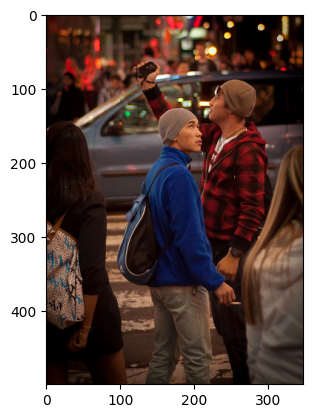

In [41]:
## SAMPLE RUN
index = 200
test_image = ds.image[index]
plt.imshow(test_image.numpy())
print("caption:" , ds.caption_0[index].numpy())

## Process this test_image
processed_test_image = process_image(test_image).unsqueeze(0)
predicted_caption = predict(cnn_feature_extraction, embedder, decoder, post_processor, processed_test_image, device=device)
print("Predicted Caption:", predicted_caption)